In [1]:
import numpy as np
import torch
from torch import nn

## Signal propagation


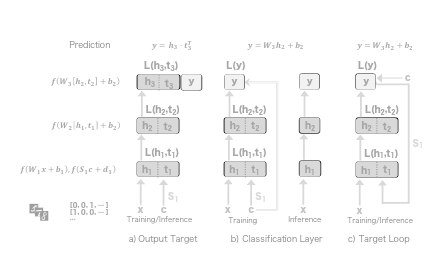


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [63]:
batch_size = 1

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1, 1, 28, 28])
Shape of y: torch.Size([1]) torch.int64


In [93]:
from torch.optim import Adam
class Layer(nn.Linear):
    
    def __init__(self, in_features, out_features,
                 bias=True, device=None, dtype=None, first=False):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
#         self.threshold = 2.0
        self.num_epochs = 1000
        self.loss_fn = nn.CrossEntropyLoss()
        self.first=first
        if self.first:
            self.target_gen = nn.Linear(10,out_features)
            self.target_opt = Adam(self.target_gen.parameters(), lr=0.03)
        
    def forward(self, h,t):
        
        if self.first:  
            t = nn.functional.one_hot(t, num_classes=10).to(torch.float32)
            print(h.shape)
            return self.relu(torch.mm(h, self.weight.T) + self.bias.unsqueeze(0)),\
                self.relu(self.target_gen(t))
        else:
            T = torch.stack((h,t), 0)
            h_next,t_next = self.relu(torch.mm(T, self.weight.T) + self.bias.unsqueeze(0))
            return h_next, t_next

    def train(self, h, t):
        for i in tqdm(range(self.num_epochs)):
            h,t = self.forward(h,t)
#             g_neg = self.forward(x_neg).pow(2).mean(1)
            # The following loss pushes pos (neg) samples to
            # values larger (smaller) than the self.threshold.
#             loss = torch.log(1 + torch.exp(torch.cat([
#                 -g_pos + self.threshold,
#                 g_neg - self.threshold]))).mean()
#             self.opt.zero_grad()
            # this backward just compute the derivative and hence
            # is not considered backpropagation.
            loss = self.loss_fun(h,t)
            loss.backward()
            if self.first:
                self.target_opt.step()
            self.opt.step()
        return self.forward(h,t).detach()

    
def visualize_sample(data, name='', idx=0):
    reshaped = data[idx].cpu().reshape(28, 28)
    plt.figure(figsize = (4, 4))
    plt.title(name)
    plt.imshow(reshaped, cmap="gray")
    plt.show()

In [94]:
class Net(nn.Module):

    def __init__(self, dims):
        super().__init__()
        self.layers = []
        self.layers.append(Layer(28*28, 500, first=True, device=torch.device("mps")))
        for d in range(len(dims) - 1):
            self.layers += [Layer(dims[d], dims[d + 1], device = torch.device("mps"))]

    def train(self, x, c):
        h, t = x, c
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            h, t = layer.train(h, t)

In [95]:
print(torch.backends.mps.is_available())

True


In [101]:

from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.datasets import MNIST

def MNIST_loaders(train_batch_size=50000, test_batch_size=10000):

    transform = Compose([
        ToTensor(),
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))])

    train_loader = DataLoader(
        MNIST('./data/', train=True,
              download=True,
              transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./data/', train=False,
              download=True,
              transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

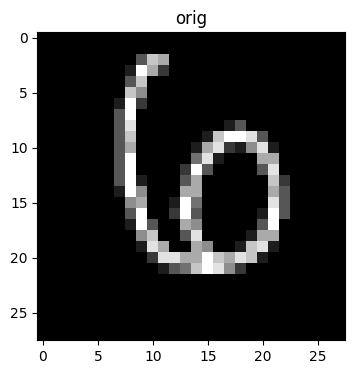

training layer 0 ...


  0%|                                                  | 0/1000 [00:00<?, ?it/s]

torch.Size([50000, 784])


  0%|                                                  | 0/1000 [00:01<?, ?it/s]


RuntimeError: Placeholder storage has not been allocated on MPS device!

In [104]:
import matplotlib.pyplot as plt
from tqdm import tqdm

torch.manual_seed(1234)
train_loader, test_loader = MNIST_loaders()

device = torch.device('mps')
x, y = next(iter(train_loader))
x, y = x.to(device), y.to(device)

for data, name in zip([x], ['orig']):
        visualize_sample(data, name)

        
net = Net([500, 500])    
net.train(x, y)

#     x_te, y_te = next(iter(test_loader))
#     x_te, y_te = x_te.cuda(), y_te.cuda()


In [ ]:
torch.autograd.set_detect_anomaly(True)
# sig prop class
class sigprop(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.target_gen = nn.Linear(8,16)
        
        self.w1 = nn.Linear(28*28,16)
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 4),
            nn.ReLU(),
            nn.Linear(4, 4),
            nn.ReLU(),
            nn.Linear(4, 10)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x, c):
        
        x = self.flatten(x)
        c = nn.functional.one_hot(c)
        c = c.to(torch.float32)
        print(c.shape)
        h1 = self.w1(x)
        t1 = self.target_gen(c)
        T = torch.stack((h1,t1), 0)
        x,y = T
        h_prev = h1
        t_prev = t1
        # updating parameters
        for l in self.linear_relu_stack:

            hl = l(h_prev)
            tl = l(t_prev)
            
            loss = self.loss_fn(hl,tl)
#             loss.backward(retain_graph=True)
            print(loss)
            
#             print('before update'.format(list(l.parameters())))
        
#             with torch.no_grad():  
#                 for param in l.parameters():
#                     param -= 1e-6 * param.grad

#             print('after update'.format(list(l.parameters().grad)))
            
            h_prev = hl
            t_prev=tl
        return x,y

In [12]:
net = sigprop()
x,test = net(X,y)
print(x.shape, test.shape)

torch.Size([1, 8])
tensor(0.2437, grad_fn=<DivBackward1>)
tensor(0.8190, grad_fn=<DivBackward1>)
tensor(0.0096, grad_fn=<DivBackward1>)
tensor(0.7827, grad_fn=<DivBackward1>)
tensor(-7.2319, grad_fn=<DivBackward1>)
torch.Size([1, 16]) torch.Size([1, 16])
